#### Continuing from `fixed_points.ipynb`, too bloated

In [40]:
import os
os.chdir('/homes/pr450/repos/research_projects/sampling_ddpm')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch

from tqdm import tqdm
from torch import Tensor as _T

from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmx
import matplotlib.colors as colors

from analysis.new_analysis.plane_alignment_utils import *


import numpy as np
from scipy.spatial.distance import pdist

In [41]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


# analysis_args = ConfigNamepace.from_yaml_path(sys.argv[1], strict_access = True)
# yaml_name = sys.argv[1].split('/')[-1].split('.')[0]
# save_base = '/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/fixed_points'
# save_path = os.path.join(save_base, yaml_name)
# _, save_path, _ = configure_logging_paths(save_path, [])
# analysis_args.write_to_yaml(os.path.join(save_path, "args.yaml"))
# print(save_path)
# run_name = analysis_args.run_name


# # run_name = 'run_c_index_cued_rnn_no_swap_0'
# # run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# # run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
# # run_name = 'run_a4_probe_cued_diffusion_flat_swap_1'
# # run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_0'
# # run_name = 'run_a6_probe_cued_diffusion_sharp_swap_2'


#run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
#run_name = 'run_a4b_probe_cued_diffusion_flat_less_swap_0'
#run_name = 'run_a4c_probe_cued_diffusion_flat_even_less_swap_0'
#run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_0'
run_name = 'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_0'
#run_name = 'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_1'

#run_name = 'run_c2_index_cued_diffusion_no_swap_1'
#run_name = 'run_c3_index_cued_diffusion_0.05_swap_0'
#run_name = 'run_c3_index_cued_diffusion_0.1_swap_0'




_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


### Get all possible stimuli

In [42]:
grid_points = 24
minimum_margin = torch.pi / task.task_variable_gen.min_sep

# Create unique feature values evenly spaced around the circle
unique_feature_values = torch.linspace(0, 2 * torch.pi, grid_points+1)[:-1]
unique_feature_values = rectify_angles(unique_feature_values)

# Create all possible combinations
stim1_grid, stim2_grid = torch.meshgrid(unique_feature_values, unique_feature_values, indexing='ij')
stim1_probe_features = stim1_grid.reshape(-1, 1)
stim2_probe_features = stim2_grid.reshape(-1, 1)

# Stack them together
all_possible_probe_features = torch.cat([stim1_probe_features, stim2_probe_features], dim=1)
all_possible_report_features = all_possible_probe_features.clone()

all_possible_probe_features = all_possible_probe_features.unsqueeze(1).repeat(1, grid_points * grid_points, 1).reshape(grid_points ** 4, 2)
all_possible_report_features = all_possible_report_features.unsqueeze(0).repeat(grid_points * grid_points, 1, 1).reshape(grid_points ** 4, 2)

all_possible_probe_features = all_possible_probe_features.repeat(2, 1)
all_possible_report_features = all_possible_report_features.repeat(2, 1)

# Create mask for valid combinations (respecting minimum margin)
probe_angle_diff = rectify_angles(all_possible_probe_features[:,0] - all_possible_probe_features[:,1])
report_angle_diff = rectify_angles(all_possible_report_features[:,0] - all_possible_report_features[:,1])
valid_trial_mask = (probe_angle_diff.abs() > minimum_margin) & (report_angle_diff.abs() > minimum_margin)

all_possible_selected_feature_idx = torch.concat([torch.zeros(grid_points ** 4), torch.ones(grid_points ** 4)]).int()

selected_feature_idx = all_possible_selected_feature_idx[valid_trial_mask]
all_probe_features = all_possible_probe_features[valid_trial_mask]
all_report_features = all_possible_report_features[valid_trial_mask]

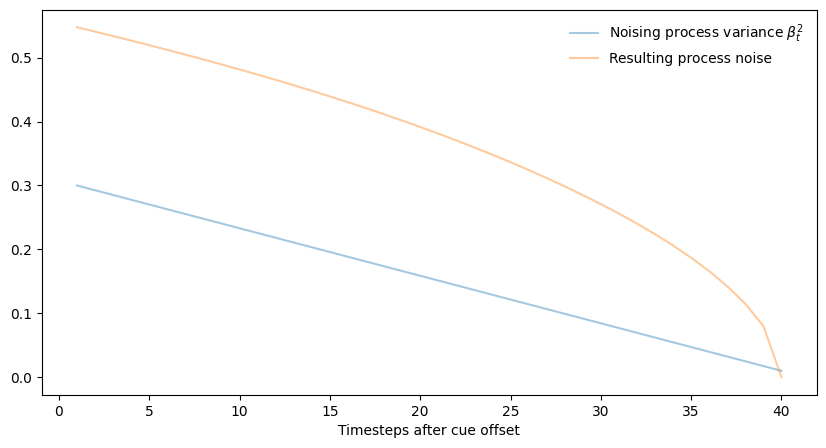

In [55]:
sch_fig, sch_axes = plt.subplots(1, 1, figsize=(10, 5))
t_axis = range(1, 41)
sch_axes.plot(
    t_axis,
    ddpm_model.sigma2xt_schedule.cpu().numpy()[::-1], label="Noising process variance $\\beta_t^2$", alpha=0.4
)
sch_axes.plot(
    t_axis,
    ddpm_model.noise_scaler_schedule.cpu().numpy()[::-1],
    label="Resulting process noise ",
    alpha=0.4,
)
sch_axes.legend(frameon=False)
sch_axes.set_xlabel('Timesteps after cue offset')

sch_fig.savefig('neurips_figures/noise_schedule.pdf')

### Fix one probe combination and run many trials

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy import stats

def create_plane_mesh(normal, center, size=100, points=10):
    """
    Create a mesh grid for visualizing a plane in 3D.
    
    Parameters:
    -----------
    normal : np.ndarray
        Normal vector to the plane, shape [3]
    center : np.ndarray
        Center point of the plane, shape [3]
    size : float
        Size of the plane mesh
    points : int
        Number of points in each dimension of the mesh
        
    Returns:
    --------
    X, Y, Z : np.ndarray
        Mesh grid coordinates for the plane
    """
    # Find two vectors perpendicular to the normal
    if np.abs(normal[0]) > np.abs(normal[1]):
        # If first component is larger, use second component for perpendicular
        v1 = np.array([-normal[2], 0, normal[0]])
    else:
        # Otherwise use first component
        v1 = np.array([0, -normal[2], normal[1]])
    
    # Normalize v1
    v1 = v1 / np.linalg.norm(v1)
    
    # v2 is perpendicular to both normal and v1
    v2 = np.cross(normal, v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Create a grid of points around the center
    grid_size = size / 2
    grid = np.linspace(-grid_size, grid_size, points)
    
    # Initialize meshgrid arrays
    X = np.zeros((points, points))
    Y = np.zeros((points, points))
    Z = np.zeros((points, points))
    
    # Fill the meshgrid by adding scaled v1 and v2 to the center
    for i, a in enumerate(grid):
        for j, b in enumerate(grid):
            point = center + a * v1 + b * v2
            X[i, j] = point[0]
            Y[i, j] = point[1]
            Z[i, j] = point[2]
    
    return X, Y, Z


def get_plane_from_pca(pca_obj, data):
    """
    Extract plane information (normal vector and center) from PCA object.
    
    Parameters:
    -----------
    pca_obj : sklearn.decomposition.PCA
        Fitted PCA object
    data : np.ndarray
        Data array that was used to fit the PCA
        
    Returns:
    --------
    normal : np.ndarray
        Normal vector to the best-fitting plane
    center : np.ndarray
        Center point of the data
    """
    # Get the normal vector (3rd principal component)
    normal = pca_obj.components_[2]
    
    # Normalize the normal vector
    normal = normal / np.linalg.norm(normal)
    
    # Get the center of the data
    center = np.mean(data, axis=0)
    
    return normal, center


def estimate_plane_size(data):
    """
    Estimate appropriate size for the plane based on data spread.
    
    Parameters:
    -----------
    data : np.ndarray
        Data points, shape [n_points, 3]
        
    Returns:
    --------
    size : float
        Suggested size for the plane visualization
    """
    # Calculate the range of data in first two principal components
    pca = PCA(n_components=2)
    projected = pca.fit_transform(data)
    
    # Calculate the span of the data in the projected space
    x_range = np.max(projected[:, 0]) - np.min(projected[:, 0])
    y_range = np.max(projected[:, 1]) - np.min(projected[:, 1])
    
    # Use the larger of the two ranges, with some margin
    size = 0.5 * max(x_range, y_range)
    
    return size


def plot_planes_with_data(mean_activity_per_bin_stim1, mean_bin_values_stim1, 
                          mean_activity_per_bin_stim2, mean_bin_values_stim2,
                          alpha=0.3, figsize=(10, 8)):
    """
    Create a 3D plot with both planes and data points.
    
    Parameters:
    -----------
    mean_activity_per_bin_stim1 : np.ndarray
        Activity data for stimulus 1, shape [n_bins, 3]
    mean_bin_values_stim1 : np.ndarray
        Bin values for stimulus 1, shape [n_bins]
    mean_activity_per_bin_stim2 : np.ndarray
        Activity data for stimulus 2, shape [n_bins, 3]
    mean_bin_values_stim2 : np.ndarray
        Bin values for stimulus 2, shape [n_bins]
    alpha : float
        Transparency level for the planes
    figsize : tuple
        Figure size (width, height) in inches
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    ax : matplotlib.axes._subplots.Axes3DSubplot
        The 3D axis object
    """
    # Create figure and 3D axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Fit PCA to data
    pca_obj_stim1 = PCA(n_components=3).fit(mean_activity_per_bin_stim1)
    pca_obj_stim2 = PCA(n_components=3).fit(mean_activity_per_bin_stim2)
    
    # Get the normal vectors and centers
    normal1, center1 = get_plane_from_pca(pca_obj_stim1, mean_activity_per_bin_stim1)
    normal2, center2 = get_plane_from_pca(pca_obj_stim2, mean_activity_per_bin_stim2)
    
    # Determine appropriate plane size
    all_data = np.vstack([mean_activity_per_bin_stim1, mean_activity_per_bin_stim2])
    plane_size = estimate_plane_size(all_data)
    
    # Create plane mesh grids
    X1, Y1, Z1 = create_plane_mesh(normal1, center1, size=plane_size)
    X2, Y2, Z2 = create_plane_mesh(normal2, center2, size=plane_size)
    
    # Plot data points and connecting lines
    ax.scatter(*mean_activity_per_bin_stim1.T, c=mean_bin_values_stim1, 
               cmap='hsv', marker='o', s=120, label='Selected stimulus 1')
    closed_data1 = np.vstack([mean_activity_per_bin_stim1, mean_activity_per_bin_stim1[0:1]])
    ax.plot(*closed_data1.T, color='grey', alpha=0.7)
    
    ax.scatter(*mean_activity_per_bin_stim2.T, c=mean_bin_values_stim2, 
               cmap='hsv', marker='v', s=120, label='Selected stimulus 2')
    closed_data2 = np.vstack([mean_activity_per_bin_stim2, mean_activity_per_bin_stim2[0:1]])
    ax.plot(*closed_data2.T, color='grey', alpha=0.7)
    
    # Plot planes
    plane1 = ax.plot_surface(X1, Y1, Z1, color='grey', alpha=alpha, shade=False)
    plane2 = ax.plot_surface(X2, Y2, Z2, color='grey', alpha=alpha, shade=False)
    
    # Remove fill effect to make them look like the paper's style
    plane1._facecolors2d = plane1._facecolor3d
    plane1._edgecolors2d = plane1._edgecolor3d
    plane2._facecolors2d = plane2._facecolor3d
    plane2._edgecolors2d = plane2._edgecolor3d
    
    # Calculate angle between planes
    cos_angle = np.abs(np.dot(normal1, normal2))
    angle_degrees = np.arccos(cos_angle) * 180 / np.pi
    
    # Add title with angle information
    # ax.set_title(f'Angle between planes: {angle_degrees:.1f}°')
    
    # Set equal aspect ratio for all axes
    # This makes the visualization look more like the paper
    max_range = max([
        np.max(mean_activity_per_bin_stim1[:, 0]) - np.min(mean_activity_per_bin_stim1[:, 0]),
        np.max(mean_activity_per_bin_stim1[:, 1]) - np.min(mean_activity_per_bin_stim1[:, 1]),
        np.max(mean_activity_per_bin_stim1[:, 2]) - np.min(mean_activity_per_bin_stim1[:, 2])
    ])
    
    mid_x = (np.max(all_data[:, 0]) + np.min(all_data[:, 0])) / 2
    mid_y = (np.max(all_data[:, 1]) + np.min(all_data[:, 1])) / 2
    mid_z = (np.max(all_data[:, 2]) + np.min(all_data[:, 2])) / 2
    
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    
    # Set axis labels
    ax.set_xlabel('PC 1', fontsize=18, labelpad=10)
    ax.set_ylabel('PC 2', fontsize=18, labelpad=10)
    ax.set_zlabel('PC 3', fontsize=18, labelpad=10)

    # 2. Increase tick label sizes
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='z', labelsize=12)

    # 3. Reduce number of ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set maximum of 5 ticks on x-axis
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Set maximum of 5 ticks on y-axis
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))  # Set maximum of 5 ticks on z-axis

    # Add legend
    ax.legend(fontsize = 18)
    
    return fig, ax


# Example usage:
"""
# Example: 
fig, ax = plot_planes_with_data(
    mean_activity_per_bin_stim1_selected, 
    mean_bin_values_stim1_selected,
    mean_activity_per_bin_stim2_selected, 
    mean_bin_values_stim2_selected,
    alpha=0.3
)
plt.show()
"""

'\n# Example: \nfig, ax = plot_planes_with_data(\n    mean_activity_per_bin_stim1_selected, \n    mean_bin_values_stim1_selected,\n    mean_activity_per_bin_stim2_selected, \n    mean_bin_values_stim2_selected,\n    alpha=0.3\n)\nplt.show()\n'

In [30]:
@torch.no_grad()
def generate_novel_samples_with_fixed_cues(fixed_probe1_val: float, fixed_probe2_val: float, num_samples: int):

    fixed_probe_pair_mask = ((all_probe_features[:,0] == fixed_probe1_val) & (all_probe_features[:,1] == fixed_probe2_val))
    fixed_probe_batch_size = fixed_probe_pair_mask.sum()

    override_stimulus_features = {
        'probe_features': all_probe_features[fixed_probe_pair_mask],
        'report_features': all_report_features[fixed_probe_pair_mask],
    }
    override_stimulus_cart_features = {}
    for k in override_stimulus_features.keys():
        override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

    override_stimulus_features_dict = dict(
        **override_stimulus_features,
        **override_stimulus_cart_features,
        cued_item_idx = selected_feature_idx[fixed_probe_pair_mask]
    )

    task_variable_dict = task.task_variable_gen.generate_variable_dict(
        batch_size = fixed_probe_batch_size,
        override_stimulus_features_dict=override_stimulus_features_dict
    )

    trial_information = task.generate_trial_information(
        batch_size=fixed_probe_batch_size, num_samples=num_samples, override_task_variable_information = task_variable_dict
    )

    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[fixed_probe_batch_size, num_samples],
        noise_scaler=1.0,
    )
    
    return novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, override_stimulus_features_dict



def calculate_swapped_trials(novel_samples_dict: dict, batch_size: int, num_samples: int, input_information: dict, display: bool,):
    selected_report_value = torch.arctan2(*novel_samples_dict['samples'][...,[1,0]].permute(2, 0, 1))
    flattened_selected_report_value = selected_report_value.reshape(batch_size * num_samples)


    actual_errors = rectify_angles(selected_report_value - input_information['report_features'][range(batch_size), input_information['cued_item_idx'], None]).numpy()
    swapped_errors = rectify_angles(selected_report_value - input_information['report_features'][range(batch_size), 1 - input_information['cued_item_idx'], None]).numpy()
    
    swapped_trials = torch.tensor(np.abs(actual_errors) > np.abs(swapped_errors)).bool()

    if display:
        fig = plt.figure(figsize = (10, 5))
        plt.hist(actual_errors.flatten(), 250, density = True)
        plt.hist(swapped_errors.flatten(), 250, density = True)
        plt.show()

        print('swapped rate:', swapped_trials.float().mean())

    return flattened_selected_report_value, swapped_trials




def seperate_activities(epoch: str, t_in_epoch: int, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, novel_samples_dict = None, novel_samples_prep_dicts = None):

    stim1_cued_mask_flattened = (input_information['cued_item_idx'] == 0.0).unsqueeze(1).expand(fixed_probe_batch_size, num_samples).flatten()
    swapped_trials_mask_flattened = swapped_trials.flatten()

    stim1_selected_mask_flattened = (stim1_cued_mask_flattened & ~swapped_trials_mask_flattened)# | (~stim1_cued_mask_flattened & swapped_trials_mask_flattened)
    stim2_selected_mask_flattened = (~stim1_cued_mask_flattened & ~swapped_trials_mask_flattened)# | (stim1_cued_mask_flattened & swapped_trials_mask_flattened)

    if epoch == 'precue':
        pcaable_activity = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,t_in_epoch,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
    elif epoch == 'postcue':
        # pcaable_activity = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
        pcaable_activity = novel_samples_dict['embedded_sample_trajectory'].data[:,:,t_in_epoch,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
    elif epoch == 'durcue':
        pcaable_activity = novel_samples_prep_dicts[2]['preparatory_trajectory'].data[:,:,t_in_epoch,:].cpu().reshape(fixed_probe_batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
    else:
        raise ValueError(epoch)


    pcaable_activity = pcaable_activity - pcaable_activity.mean(-1, keepdim = True)
    pca_obj_all_activity = PCA(n_components=3, whiten = False).fit(pcaable_activity)
    pcaeed_activity = pca_obj_all_activity.transform(pcaable_activity)

    activity_for_stim1 = pcaeed_activity[stim1_selected_mask_flattened]
    activity_for_stim2 = pcaeed_activity[stim2_selected_mask_flattened]
    colors_for_stim1 = flattened_selected_report_value[stim1_selected_mask_flattened]
    colors_for_stim2 = flattened_selected_report_value[stim2_selected_mask_flattened]

    # if epoch == 'precue':
    #     activity_for_stim1 = pcaeed_activity
    #     activity_for_stim2 = pcaeed_activity
    #     colors_for_stim1 = input_information['report_features'][:,0].unsqueeze(1).repeat(1, num_samples).flatten()
    #     colors_for_stim2 = input_information['report_features'][:,1].unsqueeze(1).repeat(1, num_samples).flatten()

    # elif epoch == 'postcue' or epoch == 'durcue':
    #     activity_for_stim1 = pcaeed_activity[stim1_selected_mask_flattened]
    #     activity_for_stim2 = pcaeed_activity[stim2_selected_mask_flattened]
    #     colors_for_stim1 = flattened_selected_report_value[stim1_selected_mask_flattened]
    #     colors_for_stim2 = flattened_selected_report_value[stim2_selected_mask_flattened]

    # else:
    #     raise ValueError(epoch)

    return {
        'activity_for_stim1': activity_for_stim1,
        'colors_for_stim1': colors_for_stim1,
        'activity_for_stim2': activity_for_stim2,
        'colors_for_stim2': colors_for_stim2,
        'pca_obj_all_activity': pca_obj_all_activity,
    }



def get_plane_angles(epoch: str, t_in_epoch: int, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display: bool, novel_samples_dict = None, novel_samples_prep_dicts = None):

    seperate_activities_info = seperate_activities(
        epoch = epoch,
        t_in_epoch = t_in_epoch,
        input_information = input_information,
        swapped_trials = swapped_trials,
        fixed_probe_batch_size = fixed_probe_batch_size,
        num_samples = num_samples,
        flattened_selected_report_value = flattened_selected_report_value,
        novel_samples_dict = novel_samples_dict,
        novel_samples_prep_dicts = novel_samples_prep_dicts,
    )

    activity_for_stim1 = seperate_activities_info['activity_for_stim1']
    colors_for_stim1 = seperate_activities_info['colors_for_stim1']
    activity_for_stim2 = seperate_activities_info['activity_for_stim2']
    colors_for_stim2 = seperate_activities_info['colors_for_stim2']
    pca_obj_all_activity = seperate_activities_info['pca_obj_all_activity']

    mean_activity_per_bin_stim1_selected, mean_bin_values_stim1_selected = bin_values(activity_for_stim1, colors_for_stim1, 16)
    mean_activity_per_bin_stim2_selected, mean_bin_values_stim2_selected = bin_values(activity_for_stim2, colors_for_stim2, 16)

    plane_angle_cos, plane_angle = compare_planes(mean_activity_per_bin_stim1_selected, mean_activity_per_bin_stim2_selected)[:2]


    if display:
        # fig = plt.figure(figsize=(20, 7))

        # ax = fig.add_subplot(1, 2, 2)
        # double_pca_obj = PCA(3, whiten = False).fit(mean_activity_per_bin_stim1_selected)
        # double_pca_stim1_space = double_pca_obj.transform(mean_activity_per_bin_stim1_selected)
        # double_pca_stim2_space = double_pca_obj.transform(mean_activity_per_bin_stim2_selected)
        # ax.scatter(*double_pca_stim1_space.T[:2], c = mean_bin_values_stim1_selected, marker = 'o')
        # ax.scatter(*double_pca_stim2_space.T[:2], c = mean_bin_values_stim1_selected, marker = 'v')
        # ax.plot(*double_pca_stim1_space.T[:2], marker = None, color = 'grey')
        # ax.plot(*double_pca_stim2_space.T[:2], marker = None, color = 'grey')
        # ax.set_title(f'plane_angle = {plane_angle}\nCos(plane angle) = {plane_angle_cos}')
        
        # fig.suptitle(f'{pca_obj_all_activity.explained_variance_ratio_.cumsum().tolist()}')
        # ax3d = fig.add_subplot(1, 1, 1, projection = '3d')
        # ax3d.scatter(*mean_activity_per_bin_stim1_selected.T, c = mean_bin_values_stim1_selected, marker = 'o')
        # ax3d.plot(*mean_activity_per_bin_stim1_selected.T, marker = None, color = 'grey')
        # ax3d.scatter(*mean_activity_per_bin_stim2_selected.T, c = mean_bin_values_stim2_selected, marker = 'v')
        # ax3d.plot(*mean_activity_per_bin_stim2_selected.T, marker = None, color = 'grey')
        # ax3d.legend()

        fig, ax3d = plot_planes_with_data(
            mean_activity_per_bin_stim1_selected, 
            mean_bin_values_stim1_selected,
            mean_activity_per_bin_stim2_selected, 
            mean_bin_values_stim2_selected,
            alpha=0.3
        )
        ax3d.xaxis.pane.fill = False
        ax3d.yaxis.pane.fill = False
        ax3d.zaxis.pane.fill = False
        ax = None

    else:
        fig, ax, ax3d = None, None, None
    
    return {
        "plane_angle_cos": plane_angle_cos,
        "plane_angle": plane_angle,
        "fig": fig,
        "ax3d": ax3d,
        "ax": ax,
        **seperate_activities_info,
    }

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


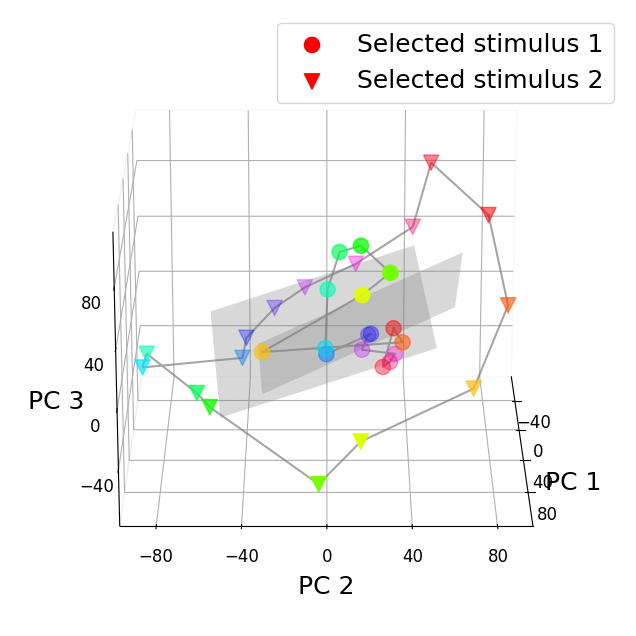

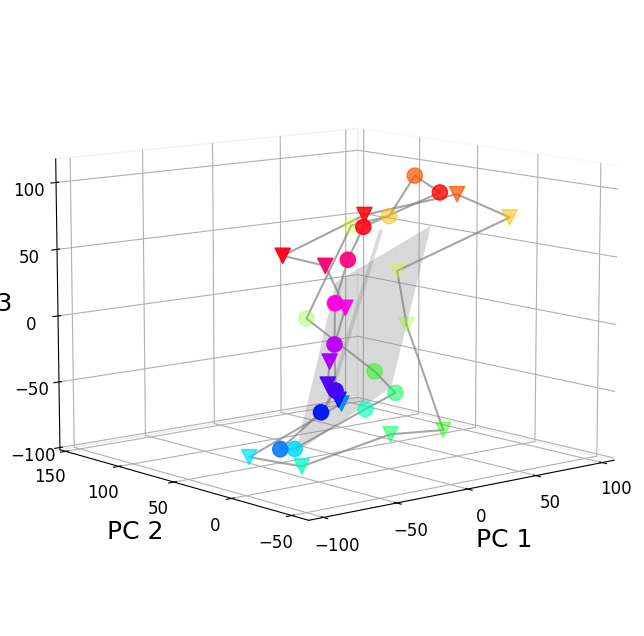

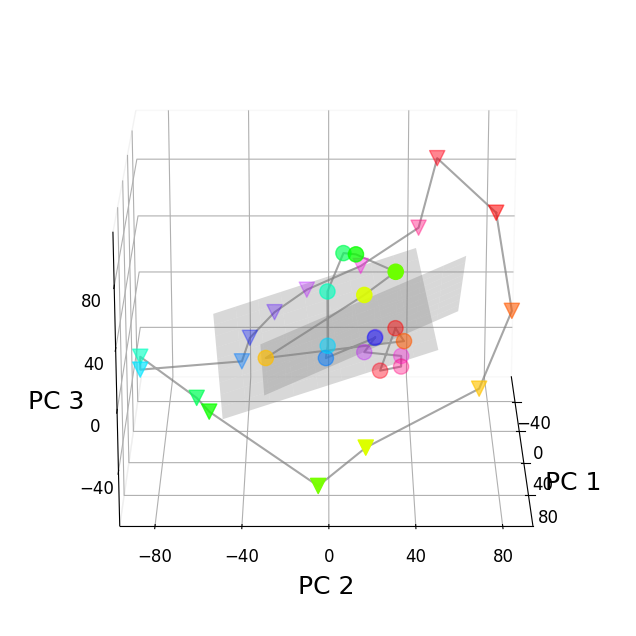

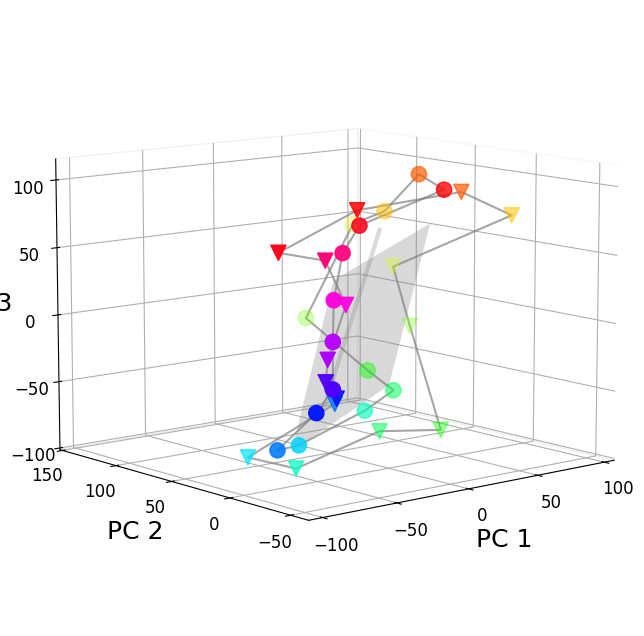

In [31]:
probe1_val = unique_feature_values[0]
probe2_val = unique_feature_values[12]

outer_novel_samples_prep_dicts, outer_novel_samples_dict, fixed_probe_batch_size, outer_input_information = generate_novel_samples_with_fixed_cues(probe1_val, probe2_val, 64)
flattened_selected_report_value, swapped_trials = calculate_swapped_trials(novel_samples_dict = outer_novel_samples_dict, batch_size = fixed_probe_batch_size, num_samples = 64, input_information = outer_input_information, display = False)

activity_info = get_plane_angles('precue', -1, outer_input_information, swapped_trials, fixed_probe_batch_size, 64, flattened_selected_report_value, display = True, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
activity_info['ax3d'].view_init(elev=20, azim=0)
activity_info['fig'].savefig('neurips_figures/plane_alignment/prestim_far_cue_cyclical.svg', transparent = True)

activity_info = get_plane_angles('postcue', 0, outer_input_information, swapped_trials, fixed_probe_batch_size, 64, flattened_selected_report_value, display = True, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
activity_info['fig'].savefig('neurips_figures/plane_alignment/postcue_far_cue_cyclical.svg', transparent = True)
activity_info['ax3d'].get_legend().remove()
activity_info['ax3d'].view_init(elev=10, azim=-130)



probe1_val = unique_feature_values[0]
probe2_val = unique_feature_values[4]

outer_novel_samples_prep_dicts, outer_novel_samples_dict, fixed_probe_batch_size, outer_input_information = generate_novel_samples_with_fixed_cues(probe1_val, probe2_val, 64)
flattened_selected_report_value, swapped_trials = calculate_swapped_trials(novel_samples_dict = outer_novel_samples_dict, batch_size = fixed_probe_batch_size, num_samples = 64, input_information = outer_input_information, display = False)

activity_info = get_plane_angles('precue', -1, outer_input_information, swapped_trials, fixed_probe_batch_size, 64, flattened_selected_report_value, display = True, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
activity_info['ax3d'].view_init(elev=20, azim=0)
activity_info['fig'].savefig('neurips_figures/plane_alignment/prestim_near_cue_cyclical.svg', transparent = True)
activity_info['ax3d'].get_legend().remove()

activity_info = get_plane_angles('postcue', 0, outer_input_information, swapped_trials, fixed_probe_batch_size, 64, flattened_selected_report_value, display = True, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
activity_info['fig'].savefig('neurips_figures/plane_alignment/postcue_near_cue_cyclical.svg', transparent = True)
activity_info['ax3d'].get_legend().remove()
activity_info['ax3d'].view_init(elev=10, azim=-130)

## Systematic plane angle over time

In [38]:
# num_precue_steps, num_cue_steps, num_postcue_steps = 15, 5, 20
num_precue_steps, num_cue_steps, num_postcue_steps = 15, 5, 40

all_probe_val_idx_diffs = range(3, 12) if 'probe' in run_name else [12]

all_fixed_probe1_val_idxs = range(24) if 'probe' in run_name else [0]
num_samples = 32 if 'probe' in run_name else 64

In [70]:
all_diffs = []
all_precue_plane_angle_coses_for_diffs = []

for val_idx_diff in all_probe_val_idx_diffs:

    print(f'Starting diff {val_idx_diff}')

    precue_plane_angle_coses_for_diff = []

    for fixed_probe1_val_idx in all_fixed_probe1_val_idxs:

        fixed_probe2_val_idx = (fixed_probe1_val_idx + val_idx_diff) % grid_points

        fixed_probe1_val = unique_feature_values[fixed_probe1_val_idx]
        fixed_probe2_val = unique_feature_values[fixed_probe2_val_idx]

        outer_novel_samples_prep_dicts, outer_novel_samples_dict, fixed_probe_batch_size, outer_input_information = generate_novel_samples_with_fixed_cues(fixed_probe1_val, fixed_probe2_val, num_samples)

        flattened_selected_report_value, swapped_trials = calculate_swapped_trials(novel_samples_dict = outer_novel_samples_dict, batch_size = fixed_probe_batch_size, num_samples = num_samples, input_information = outer_input_information, display = False)

        precue_plane_angle_coses = []

        for i in range(num_precue_steps):
            activity_info = get_plane_angles('precue', i, outer_input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = False, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
            precue_plane_angle_coses.append(activity_info['plane_angle_cos'])

        for i in range(num_cue_steps):
            activity_info = get_plane_angles('durcue', i, outer_input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = False, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
            precue_plane_angle_coses.append(activity_info['plane_angle_cos'])

        for i in range(num_postcue_steps):
            activity_info = get_plane_angles('postcue', i, outer_input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = False, novel_samples_dict = outer_novel_samples_dict, novel_samples_prep_dicts = outer_novel_samples_prep_dicts)
            precue_plane_angle_coses.append(activity_info['plane_angle_cos'])

        #fig, axes = plt.subplots(1, 2, figsize = (10, 5))
        #axes[0].plot(precue_plane_angle_coses)

        precue_plane_angle_coses_for_diff.append(precue_plane_angle_coses)

    all_precue_plane_angle_coses_for_diffs.append(precue_plane_angle_coses_for_diff)
    all_diffs.append(val_idx_diff)


all_precue_plane_angle_coses_for_diffs = np.array(all_precue_plane_angle_coses_for_diffs)

np.save(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/plane_alignment_new/all_precue_plane_angle_coses_for_diffs_{run_name}.npy', all_precue_plane_angle_coses_for_diffs)

Starting diff 12
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


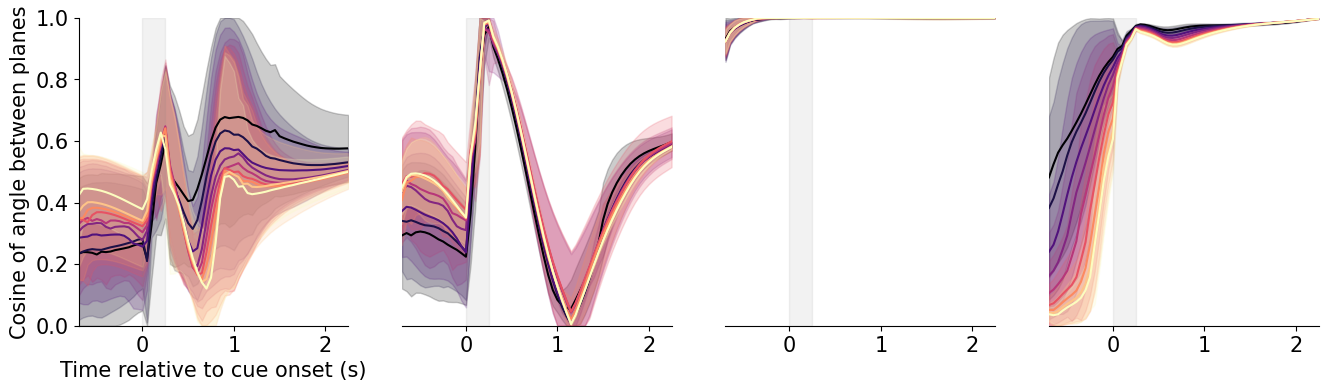

In [46]:
def generate_cmap(lrn: str, all_probe_val_idx_diffs: list[int]):
    magma = plt.get_cmap("magma")
    cNorm = colors.Normalize(vmin=all_probe_val_idx_diffs[0], vmax=all_probe_val_idx_diffs[-1])
    cmap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
    cmap.set_array([])
    return cmap

dt = 0.05

loading_run_names = {
    'run_a2_probe_cued_rnn_no_swap_1': 'Task optimal',
    'run_a3_probe_cued_diffusion_no_swap_1': 'Diffusion with no swaps',
    'run_a4c_probe_cued_diffusion_flat_even_less_swap_0': 'Diffusion with constant 0.05 swap prob',
    #'run_a4b_probe_cued_diffusion_flat_less_swap_0': 'Diffusion with constant 0.08 swap prob',
    'run_a5b_probe_cued_diffusion_cyclical_less_swap_0': 'Diffusion with smooth swap function',
    #'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_0': 'Diffusion with smooth swap function',
}
fig_name = 'probe'
same_fig = False
all_probe_val_idx_diffs = range(3, 12)

# loading_run_names = {
#     'run_c2_index_cued_diffusion_no_swap_1': ('darkgreen', '0.0'),
#     'run_c3_index_cued_diffusion_0.05_swap_0': ('limegreen', '0.05'),
#     'run_c3_index_cued_diffusion_0.1_swap_0': ('springgreen', '0.1'),
#     'run_c_index_cued_rnn_no_swap_0': ('grey', 'Task\noptimised'),
# }
# fig_name = 'index'
# same_fig = True
# all_probe_val_idx_diffs = [12]


figsize = 4
if same_fig:
    fig, axes = plt.subplots(1, 1, figsize = (figsize, figsize))
    axes = [axes] * len(loading_run_names)
else:
    fig, axes = plt.subplots(1, len(loading_run_names), figsize = (len(loading_run_names) * figsize, figsize))

for ax, loading_run_name in zip(axes, loading_run_names.keys()):

    # with open(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/plane_alignment/all_precue_plane_angle_coses_for_diffs_{loading_run_name}.npy', 'rb') as f:
    with open(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/plane_alignment_new/all_precue_plane_angle_coses_for_diffs_{loading_run_name}.npy', 'rb') as f:
        all_precue_plane_angle_coses_for_diffs = np.load(f, allow_pickle=True)

    means = all_precue_plane_angle_coses_for_diffs.mean(1)
    stds = all_precue_plane_angle_coses_for_diffs.std(1)

    cmap = generate_cmap(loading_run_name, all_probe_val_idx_diffs)

    for (diff, mean_line, std_line) in zip(all_probe_val_idx_diffs, means, stds):

        # mean_line = np.concatenate([mean_line[:num_cue_steps + num_precue_steps], mean_line[num_cue_steps + num_precue_steps::2]])
        # std_line = np.concatenate([std_line[:num_cue_steps + num_precue_steps], std_line[num_cue_steps + num_precue_steps::2]])
        time_axis = [(i - num_precue_steps) * dt for i in range(1, 1 + mean_line.shape[-1])]
        
        upper = np.clip(mean_line + std_line, 0.0, 1.0)
        lower = np.clip(mean_line - std_line, 0.0, 1.0)

        probe_diff = diff / 24 / np.pi * 180          ### XXX: Hacky - save probe diffs directly!

        label = None if len(all_probe_val_idx_diffs) > 1 else loading_run_names[loading_run_name][1]
        color = cmap.to_rgba(diff) if len(all_probe_val_idx_diffs) > 1 else loading_run_names[loading_run_name][0]

        #ax.plot(time_axis, mean_line, color = cmap.to_rgba(diff), label = round(probe_diff, 3))
        ax.plot(time_axis, mean_line, color = color, label = label)
        ax.fill_between(time_axis, lower, upper, alpha = 0.2, color = color)

    ax.fill_betweenx(
        [0.0, 1.0], 
        (np.array([num_precue_steps, num_precue_steps]) - num_precue_steps) * dt,
        (np.array([num_cue_steps + num_precue_steps, num_cue_steps + num_precue_steps]) - num_precue_steps) * dt,
        alpha = 0.1, color = 'grey'
    )

    # ax.set_xlabel('Time, cue presentation highlighted')
    # ax.set_title(loading_run_names[loading_run_name])

    ax.set_ylim(0.0, 1.0)
    ax.set_xlim(time_axis[0], time_axis[-1])

axes[0].set_ylabel('Cosine of angle between planes', fontsize = 15)

for iax, ax in enumerate(axes):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if iax and not same_fig:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    else:
        ax.set_xlabel('Time relative to cue onset (s)', fontsize = 15)

# axes[1].legend(title = 'Probe difference (degrees)', loc='lower center')

# if len(all_probe_val_idx_diffs) == 1:
#     legend = ax.legend(frameon=False, title = 'Index cued probability of swap', bbox_to_anchor=(1.0, 1.3), fontsize = 15)
#     plt.setp(legend.get_title(),fontsize=15)
#     fig.tight_layout()




fig.savefig(f'neurips_figures/plane_alignment/{fig_name}_alignment_over_time.svg', transparent = True) 

## Misprojection

In [35]:
def generate_many_trials_data(fixed_probe1_val_idx: int, fixed_probe2_val_idx: int, plot: bool = False):
    fixed_probe1_val = unique_feature_values[fixed_probe1_val_idx]
    fixed_probe2_val = unique_feature_values[fixed_probe2_val_idx]

    novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information = generate_novel_samples_with_fixed_cues(fixed_probe1_val, fixed_probe2_val, num_samples)
    flattened_selected_report_value, swapped_trials = calculate_swapped_trials(novel_samples_dict = novel_samples_dict, batch_size = fixed_probe_batch_size, num_samples = num_samples, input_information = input_information, display = False)

    if plot:
        fig_precue = get_plane_angles('precue', -5, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = True, novel_samples_dict = novel_samples_dict, novel_samples_prep_dicts = novel_samples_prep_dicts)
        fig_postcue = get_plane_angles('postcue', 4, input_information, swapped_trials, fixed_probe_batch_size, num_samples, flattened_selected_report_value, display = True, novel_samples_dict = novel_samples_dict, novel_samples_prep_dicts = novel_samples_prep_dicts)

        fig_precue['fig'].suptitle('5 steps before cue onset')
        fig_postcue['fig'].suptitle('5 steps after cue offset')

        fig_precue['ax3d'].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_postcue['ax3d'].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_precue['ax3d'].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_postcue['ax3d'].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_precue['ax3d'].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        fig_postcue['ax3d'].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    return novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information, flattened_selected_report_value, swapped_trials

In [36]:
def generate_misprojection_planes(fixed_stim_value_idx, input_information, novel_samples_dict, novel_samples_prep_dicts, plot: bool = False):

    fixed_stim1_value = unique_feature_values[fixed_stim_value_idx]        

    stim1_cued_mask = (input_information['cued_item_idx'] == 0) & (input_information['report_features'][:,0] == fixed_stim1_value)
    stim2_cued_mask = (input_information['cued_item_idx'] == 1) & (input_information['report_features'][:,0] == fixed_stim1_value)

    stim2_report_when_stim1_cued = input_information['report_features'][stim1_cued_mask][:,1]
    stim2_report_when_stim1_distractor = input_information['report_features'][stim2_cued_mask][:,1]

    final_timestep_many_trials_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()
    # final_timestep_many_trials_data = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,-1].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()

    stim1_as_cued_many_trials_data = final_timestep_many_trials_data[stim1_cued_mask]
    stim1_as_distractor_many_trials_data = final_timestep_many_trials_data[stim2_cued_mask]
    stim1_as_cued_many_trials_data_reshaped = stim1_as_cued_many_trials_data.reshape(num_samples * stim1_as_cued_many_trials_data.shape[0], ddpm_model.sample_ambient_dims[0])
    stim1_as_distractor_many_trials_data_reshaped = stim1_as_distractor_many_trials_data.reshape(num_samples * stim1_as_distractor_many_trials_data.shape[0], ddpm_model.sample_ambient_dims[0])

    stim2_report_when_stim1_cued_many_trials = stim2_report_when_stim1_cued.unsqueeze(1).repeat(1, num_samples).reshape(-1)
    stim2_report_when_stim1_distractor_many_trials = stim2_report_when_stim1_distractor.unsqueeze(1).repeat(1, num_samples).reshape(-1)

    pca_obj_stim1_as_cued_many_trials = PCA(n_components=4, whiten = False).fit(stim1_as_cued_many_trials_data_reshaped)

    pcaed_stim1_as_cued_many_trials_reshaped = pca_obj_stim1_as_cued_many_trials.transform(stim1_as_cued_many_trials_data_reshaped)
    
    if plot:
        import matplotlib.pyplot as plt
        import matplotlib.colors as mcolors
        import numpy as np
        from matplotlib import cm
        
        pcaed_stim1_as_distractor_many_trials_reshaped = pca_obj_stim1_as_cued_many_trials.transform(stim1_as_distractor_many_trials_data_reshaped)

        fig_stim1 = plt.figure(figsize = (10, 5))
        ax_color_by_report = fig_stim1.add_subplot(1, 2, 1, projection = '3d')
        ax_color_by_report_stim1_distractor = fig_stim1.add_subplot(1, 2, 2, projection = '3d')
        
        # ======= CHANGE 1: Reduce the number of ticks and increase fontsize =======
        for ax in [ax_color_by_report, ax_color_by_report_stim1_distractor]:
            # Set fewer ticks on each axis
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            ax.zaxis.set_major_locator(plt.MaxNLocator(5))
            
            # Increase tick label size
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)
            ax.tick_params(axis='z', labelsize=12)
            
            # ======= CHANGE 4: Reduce number of gridlines =======
            ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)
            
            # Make background panes transparent
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            
            # ======= CHANGE 3: Label axes PC1, PC2, PC3 =======
            ax.set_xlabel('Shared\nPC1', fontsize=14, labelpad=10)
            ax.set_ylabel('Shared\nPC2', fontsize=14, labelpad=10)
            ax.set_zlabel('Shared\nPC3', fontsize=14, labelpad=10)
        
        # ======= CHANGE 2: Use RGB cycle for coloring =======
        # Create a normalization for the report values
        stim2_min = min(stim2_report_when_stim1_cued_many_trials.min(), stim2_report_when_stim1_distractor_many_trials.min())
        stim2_max = max(stim2_report_when_stim1_cued_many_trials.max(), stim2_report_when_stim1_distractor_many_trials.max())
        
        # Function to convert angle to RGB color (full spectrum)
        def angle_to_rgb(angle, min_angle, max_angle):
            # Normalize angle to [0, 1]
            normalized = (angle - min_angle) / (max_angle - min_angle)
            # Convert to hue (0-1) and then to RGB
            return plt.cm.hsv(normalized)
        
        # Create color arrays for the scatter plots
        colors_stim1_cued = np.array([angle_to_rgb(val, stim2_min, stim2_max) for val in stim2_report_when_stim1_cued_many_trials])
        colors_stim1_distractor = np.array([angle_to_rgb(val, stim2_min, stim2_max) for val in stim2_report_when_stim1_distractor_many_trials])
        
        # Set titles
        ax_color_by_report.set_title('Stim1 cued and fixed across dots.\nColor = stim2 report', fontsize=14)
        ax_color_by_report_stim1_distractor.set_title('Stim2 cued, stim1 fixed across dots.\nColor = stim2 report.\nSame PCs as axis 1', fontsize=14)

        # Scatter plots with new coloring
        correct_mask_cued = ~swapped_trials[stim1_cued_mask].flatten()
        swapped_mask_cued = swapped_trials[stim1_cued_mask].flatten()
        
        correct_mask_distractor = ~swapped_trials[stim2_cued_mask].flatten()
        swapped_mask_distractor = swapped_trials[stim2_cued_mask].flatten()
        
        # Plot for stim1 cued
        ax_color_by_report.scatter(
            pcaed_stim1_as_cued_many_trials_reshaped[correct_mask_cued, 0],
            pcaed_stim1_as_cued_many_trials_reshaped[correct_mask_cued, 1],
            pcaed_stim1_as_cued_many_trials_reshaped[correct_mask_cued, 2],
            c=colors_stim1_cued[correct_mask_cued], 
            label='correct trials'
        )
        
        ax_color_by_report.scatter(
            pcaed_stim1_as_cued_many_trials_reshaped[swapped_mask_cued, 0],
            pcaed_stim1_as_cued_many_trials_reshaped[swapped_mask_cued, 1],
            pcaed_stim1_as_cued_many_trials_reshaped[swapped_mask_cued, 2],
            c=colors_stim1_cued[swapped_mask_cued], 
            marker='x', 
            label='swapped trials'
        )

        ax_color_by_report.legend()
        
        # Plot for stim1 as distractor
        ax_color_by_report_stim1_distractor.scatter(
            pcaed_stim1_as_distractor_many_trials_reshaped[correct_mask_distractor, 0],
            pcaed_stim1_as_distractor_many_trials_reshaped[correct_mask_distractor, 1],
            pcaed_stim1_as_distractor_many_trials_reshaped[correct_mask_distractor, 2],
            c=colors_stim1_distractor[correct_mask_distractor], 
            label='correct trials'
        )
        
        ax_color_by_report_stim1_distractor.scatter(
            pcaed_stim1_as_distractor_many_trials_reshaped[swapped_mask_distractor, 0],
            pcaed_stim1_as_distractor_many_trials_reshaped[swapped_mask_distractor, 1],
            pcaed_stim1_as_distractor_many_trials_reshaped[swapped_mask_distractor, 2],
            c=colors_stim1_distractor[swapped_mask_distractor], 
            marker='x', 
            label='swapped trials'
        )

    else:
        fig_stim1 = None

    return fig_stim1, fixed_stim1_value, pca_obj_stim1_as_cued_many_trials.components_, pcaed_stim1_as_cued_many_trials_reshaped, swapped_trials[stim1_cued_mask].flatten()

In [80]:
#run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
#run_name = 'run_a4b_probe_cued_diffusion_flat_less_swap_0'
#run_name = 'run_a4c_probe_cued_diffusion_flat_even_less_swap_0'
#run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_0'
run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_1'


_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess
for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False

### Note - the below is for the larger than realistic swap function!

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


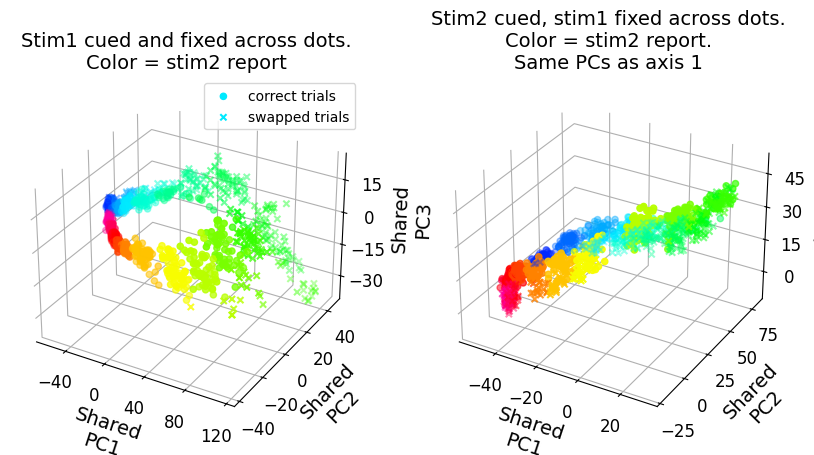

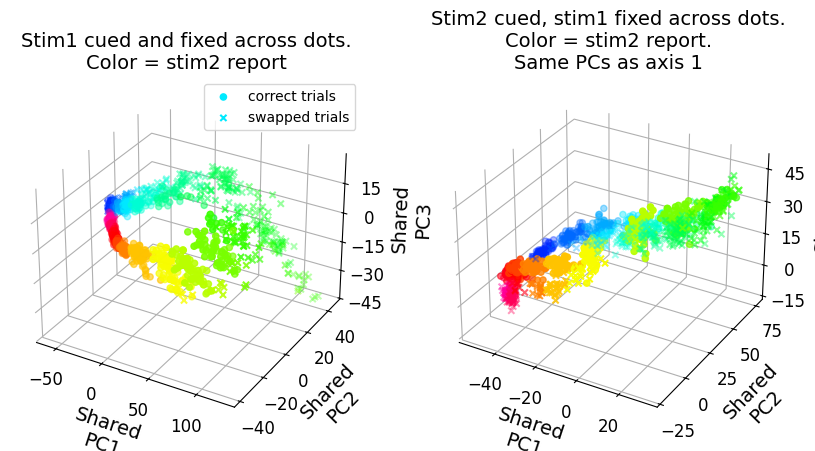

In [39]:
novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information, flattened_selected_report_value, swapped_trials = generate_many_trials_data(0, 4, False)
fig_stim1, *_ = generate_misprojection_planes(6, input_information, novel_samples_dict, novel_samples_prep_dicts, plot=True)
fig_stim1.savefig(f'neurips_figures/misprojection/near_cue_scatter.svg', transparent = True) 


novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information, flattened_selected_report_value, swapped_trials = generate_many_trials_data(0, 12, False)
fig_stim1, *_ = generate_misprojection_planes(6, input_information, novel_samples_dict, novel_samples_prep_dicts, plot=True)
fig_stim1.savefig(f'neurips_figures/misprojection/far_cue_scatter.svg', transparent = True) 
pass

# For different probe features, but the same stim1 fix, we should have the same 3d subspaces above (2 for color + 1 for target vs. distractor)

In [109]:
## COLLECTING DATA ACROSS DIFFERENT 

across_fixed_report_all_fixed_probe_values = []
across_fixed_report_all_post_comps = []
across_fixed_report_all_projection_pcaed = []
across_fixed_report_all_many_trials_swapped_trials = []

for j in range(0, 12):

    all_fixed_probe_values = []
    all_post_comps = []
    all_projection_pcaed = []
    all_many_trials_swapped_trials = []

    for i1 in tqdm(range(0, 12, 2)):
        for i2 in tqdm(range(0, 12, 2)):
            try:
                novel_samples_prep_dicts, novel_samples_dict, fixed_probe_batch_size, input_information, flattened_selected_report_value, swapped_trials =\
                    generate_many_trials_data(i1, i2, False)
            except RuntimeError:
                continue

            _, fixed_stim1_value, new_post_comp, projection_pcaed, relevant_swapped_trials = generate_misprojection_planes(j, input_information, novel_samples_dict, novel_samples_prep_dicts, plot=False)
            all_fixed_probe_values.append(input_information['probe_features'][0].tolist())
            all_post_comps.append(new_post_comp)
            all_projection_pcaed.append(projection_pcaed)
            all_many_trials_swapped_trials.append(relevant_swapped_trials)

    across_fixed_report_all_fixed_probe_values.append(all_fixed_probe_values)
    across_fixed_report_all_post_comps.append(all_post_comps)
    across_fixed_report_all_projection_pcaed.append(all_projection_pcaed)
    across_fixed_report_all_many_trials_swapped_trials.append(all_many_trials_swapped_trials)

  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.92s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.67s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:04<00:04,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.54s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:07<00:01,  1.55s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.96s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.70s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:04<00:04,  1.61s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.59s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.94s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.67s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:04<00:04,  1.60s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.57s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.57s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.94s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:05<00:04,  1.62s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.93s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.70s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:05<00:04,  1.63s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.60s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.61s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.96s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:05<00:04,  1.62s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.59s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.59s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.98s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.73s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:05<00:04,  1.63s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.59s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.96s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.69s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:04<00:04,  1.61s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.95s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:04<00:04,  1.61s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.56s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.94s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.69s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:04<00:04,  1.61s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.94s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:05<00:04,  1.62s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.60s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


  0%|          | 0/6 [00:00<?, ?it/s]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 17%|█▋        | 1/6 [00:01<00:09,  1.95s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 50%|█████     | 3/6 [00:05<00:04,  1.64s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 67%|██████▋   | 4/6 [00:06<00:03,  1.60s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


 83%|████████▎ | 5/6 [00:08<00:01,  1.60s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


torch.Size([4, 6, 16])


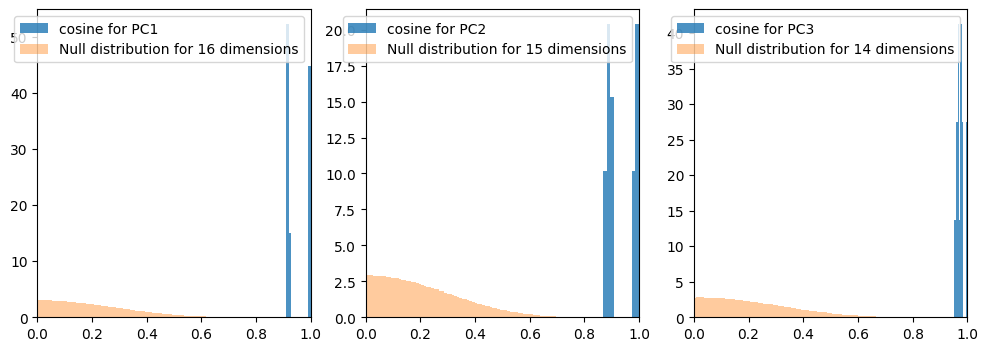

In [98]:
## Plotting all PCs' alignments against null hypothesis (same report)

all_post_comps = across_fixed_report_all_post_comps[0]

all_post_comps_stacked = torch.tensor(np.stack(all_post_comps, 1))  # [3D, difference probe combinations, N = 16]
print(all_post_comps_stacked.shape)

triu_indices = torch.triu_indices(len(all_post_comps), len(all_post_comps), 1)
all_post_comps_cosines = [torch.mm(vecs, vecs.T).abs()[*triu_indices] for vecs in all_post_comps_stacked]


fig, axes = plt.subplots(1, 3, figsize = (12, 4), sharex = True)
for i, (ax, apcc) in enumerate(zip(axes, all_post_comps_cosines[:3])):

    ax.hist(apcc.numpy(), 10, density = True, alpha = 0.8, label = f'cosine for PC{i+1}')
    test_pop_size = 1024

    random_vectors = torch.randn(test_pop_size, 16 - i)
    random_vectors = random_vectors / random_vectors.square().sum(-1)[:,None].sqrt()

    assert torch.isclose(random_vectors.square().sum(-1), torch.tensor(1.0)).all()

    test_pop_cosines = torch.mm(random_vectors, random_vectors.T)[*torch.triu_indices(test_pop_size, test_pop_size, 1)].abs()
    assert test_pop_cosines.shape[0] == (test_pop_size * (test_pop_size-1) * 0.5)

    ax.hist(test_pop_cosines.numpy(), 100, density = True, alpha = 0.4, label = f"Null distribution for {16 - i} dimensions")

    ax.set_xlim(0, 1)
    ax.legend()

<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2050345/2439614867.py:52: SyntaxWarning: invalid escape sequence '\m'
  axes.hist(test_pop_cosines.numpy(), 20, histtype=u'step', color = 'gray', linewidth = 4, density = True, alpha = 0.4, label = "Null distribution for $\mathbb{R}^n$")
/tmp/ipykernel_2050345/2439614867.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fixed_report_value_diff = rectify_angles(torch.tensor(fixed_report_value_1 - fixed_report_value_2)).abs()


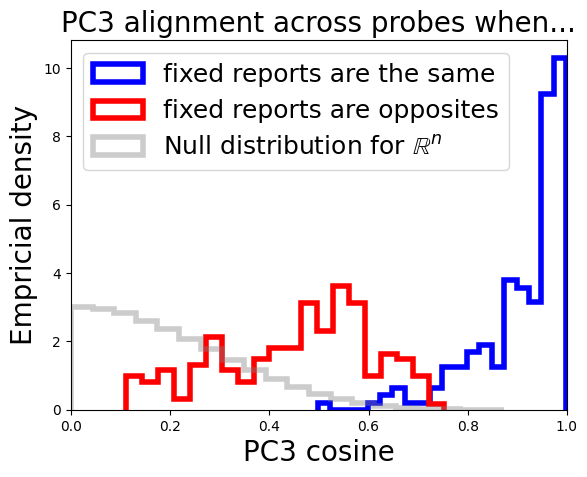

In [225]:


## Plotting PC3 alignment against null hypothesis, for both within one report, and across all reports

all_cross_post_comps_cosines = np.zeros([len(across_fixed_report_all_post_comps), len(across_fixed_report_all_post_comps)])

report_dist_to_hist = {}
report_dist_to_actual_dist = {}

for i1, all_post_comps1 in enumerate(across_fixed_report_all_post_comps):
    for i2, all_post_comps2 in enumerate(across_fixed_report_all_post_comps):

        fixed_report_value_1 = unique_feature_values[i1]  
        fixed_report_value_2 = unique_feature_values[i2]
        idx_diff = abs(i1-i2)
        fixed_report_value_diff = rectify_angles(torch.tensor(fixed_report_value_1 - fixed_report_value_2)).abs()
        
        all_post_comps1_stacked = torch.tensor(np.stack(all_post_comps1, 1))  # [3D, difference probe combinations, N = 16]
        all_post_comps2_stacked = torch.tensor(np.stack(all_post_comps2, 1))  # [3D, difference probe combinations, N = 16]

        triu_indices = torch.triu_indices(len(all_post_comps1), len(all_post_comps1), 1)
        cross_post_comps_cosines = torch.mm(all_post_comps1_stacked[2], all_post_comps2_stacked[2].T).abs()[*triu_indices]

        report_dist_to_hist[idx_diff] = report_dist_to_hist.get(fixed_report_value_diff, []) + cross_post_comps_cosines.tolist()
        report_dist_to_actual_dist[idx_diff] = fixed_report_value_diff


# magma = plt.get_cmap("magma")
# cNorm = colors.Normalize(vmin=min(report_dist_to_hist), vmax=max(report_dist_to_hist))
# cmap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
# cmap.set_array([])

# for k, v in report_dist_to_hist.items():
#     plt.hist(v, 10, label = report_dist_to_actual_dist[k],  histtype=u'step', linewidth = 4, color = cmap.to_rgba(k))

# plt.legend()

test_pop_size = 1024

random_vectors = torch.randn(test_pop_size, 16)
random_vectors = random_vectors / random_vectors.square().sum(-1)[:,None].sqrt()

assert torch.isclose(random_vectors.square().sum(-1), torch.tensor(1.0)).all()

test_pop_cosines = torch.mm(random_vectors, random_vectors.T)[*torch.triu_indices(test_pop_size, test_pop_size, 1)].abs()
assert test_pop_cosines.shape[0] == (test_pop_size * (test_pop_size-1) * 0.5)


fig, axes = plt.subplots(1)

axes.set_title("PC3 alignment across probes when...", fontsize = 20)
axes.hist(report_dist_to_hist[0], 20, histtype=u'step', linewidth = 4, color = 'blue', density = True, label = "fixed reports are the same")
axes.hist(report_dist_to_hist[11], 20, histtype=u'step', linewidth = 4, color = 'red', density = True, label = "fixed reports are opposites")
axes.hist(test_pop_cosines.numpy(), 20, histtype=u'step', color = 'gray', linewidth = 4, density = True, alpha = 0.4, label = "Null distribution for $\mathbb{R}^n$")

axes.set_xlabel('PC3 cosine', fontsize = 20)
axes.set_ylabel('Empricial density', fontsize = 20)

axes.legend(fontsize = 18)

axes.set_xlim(-0.0, 1.0)

fig.savefig('neurips_figures/misprojection/PC3_alignment.svg', transparent = True)

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.transforms as mtransforms

def create_perfect_rgb_gradients(data, cmap='viridis', figsize=(10, 8), title=None, 
                                x_label="Fixed report value", y_label="Fixed report value",
                                vmin=None, vmax=None):
    """
    Create an imshow plot with perfectly aligned RGB color wheel gradients.
    
    Parameters:
    -----------
    data : ndarray
        2D array of data to display
    cmap : str or Colormap
        Colormap to use for the imshow
    figsize : tuple
        Figure size (width, height) in inches
    title : str, optional
        Plot title
    x_label, y_label : str
        Axis labels
    vmin, vmax : float
        Value range for imshow
        
    Returns:
    --------
    fig : Figure
        The matplotlib figure
    ax : Axes
        The matplotlib axes
    """
    # Create figure with extra space for gradients and colorbar
    fig = plt.figure(figsize=figsize)
    
    # Calculate positions for the axes
    left_margin = 0.15
    right_margin = 0.85
    bottom_margin = 0.15
    top_margin = 0.95
    
    # Create main plot axis
    main_ax = fig.add_axes([left_margin, bottom_margin, right_margin-left_margin, top_margin-bottom_margin])
    
    # Get the dimensions of the data
    n_rows, n_cols = data.shape
    
    # Determine axis limits
    x_min, x_max = 0, n_cols
    y_min, y_max = 0, n_rows
    
    # Plot the data with imshow
    im = main_ax.imshow(data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    
    # Set explicit tick positions to match data points
    main_ax.set_xticks(np.arange(0, n_cols))
    main_ax.set_yticks(np.arange(0, n_rows))
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.88, bottom_margin, 0.03, top_margin-bottom_margin])
    cbar = plt.colorbar(im, cax=cbar_ax)
    
    # Create EXACTLY positioned RGB gradient axes
    
    # 1. Get the exact pixel position and size of the main axis
    bbox = main_ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width_inches, height_inches = bbox.width, bbox.height
    
    # Create a tight layout manager
    fig.tight_layout()
    
    # 2. Create absolute-positioned gradient axes
    # X-axis gradient (bottom)
    x_gradient_height = 0.03  # Height in figure coordinates
    x_gradient_ax = fig.add_axes([left_margin, bottom_margin-x_gradient_height-0.02, 
                                  right_margin-left_margin, x_gradient_height])
    
    # Y-axis gradient (left)
    y_gradient_width = 0.03   # Width in figure coordinates
    y_gradient_ax = fig.add_axes([left_margin-y_gradient_width-0.02, bottom_margin,
                                  y_gradient_width, top_margin-bottom_margin])
    
    # Create high-resolution RGB color wheel gradients
    create_color_wheel_gradient_x(x_gradient_ax, 0, n_cols-1, 1000)
    create_color_wheel_gradient_y(y_gradient_ax, 0, n_rows-1, 1000)
    
    # Set axis limits to perfectly match main plot
    x_gradient_ax.set_xlim(main_ax.get_xlim())
    y_gradient_ax.set_ylim(main_ax.get_ylim())
    
    # Copy tick positions from main plot
    x_gradient_ax.set_xticks(main_ax.get_xticks())
    y_gradient_ax.set_yticks(main_ax.get_yticks())
    
    # Hide main plot tick labels (x-axis)
    main_ax.set_xticklabels([])
    main_ax.set_xlabel('')
    
    # Remove irrelevant ticks
    x_gradient_ax.set_yticks([])
    y_gradient_ax.set_xticks([])
    
    # Add axis labels
    x_gradient_ax.set_xlabel(x_label, fontsize=15, labelpad=10)
    y_gradient_ax.set_ylabel(y_label, fontsize=15, labelpad=10)
    
    # Set the title if provided
    if title:
        main_ax.set_title(title, fontsize=20)
    
    return fig, main_ax, [x_gradient_ax, y_gradient_ax]

def create_color_wheel_gradient_x(ax, min_val, max_val, resolution=1000):
    """
    Create a perfectly positioned horizontal RGB color wheel gradient.
    
    Parameters:
    -----------
    ax : Axes
        The matplotlib axes to draw on
    min_val, max_val : float
        Minimum and maximum data values
    resolution : int
        Number of color points for smooth gradient
    """
    # Create the gradient array
    gradient = np.zeros((1, resolution, 3))
    
    # Fill with colors from the RGB wheel
    for i in range(resolution):
        # Map position to hue [0-1]
        pos = i / (resolution - 1)
        # Convert to RGB
        gradient[0, i] = mcolors.hsv_to_rgb([pos, 1.0, 1.0])
    
    # Display with exact data coordinate mapping
    extent = [min_val, max_val, 0, 1]
    ax.imshow(gradient, aspect='auto', extent=extent, origin='lower')

def create_color_wheel_gradient_y(ax, min_val, max_val, resolution=1000):
    """
    Create a perfectly positioned vertical RGB color wheel gradient.
    
    Parameters:
    -----------
    ax : Axes
        The matplotlib axes to draw on
    min_val, max_val : float
        Minimum and maximum data values
    resolution : int
        Number of color points for smooth gradient
    """
    # Create the gradient array
    gradient = np.zeros((resolution, 1, 3))
    
    # Fill with colors from the RGB wheel
    for i in range(resolution):
        # Map position to hue [0-1]
        pos = i / (resolution - 1)
        # Convert to RGB
        gradient[i, 0] = mcolors.hsv_to_rgb([pos, 1.0, 1.0])
    
    # Display with exact data coordinate mapping
    extent = [0, 1, min_val, max_val]
    ax.imshow(gradient, aspect='auto', extent=extent, origin='lower')


/tmp/ipykernel_2050345/82053014.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


(-0.5, 11.5)

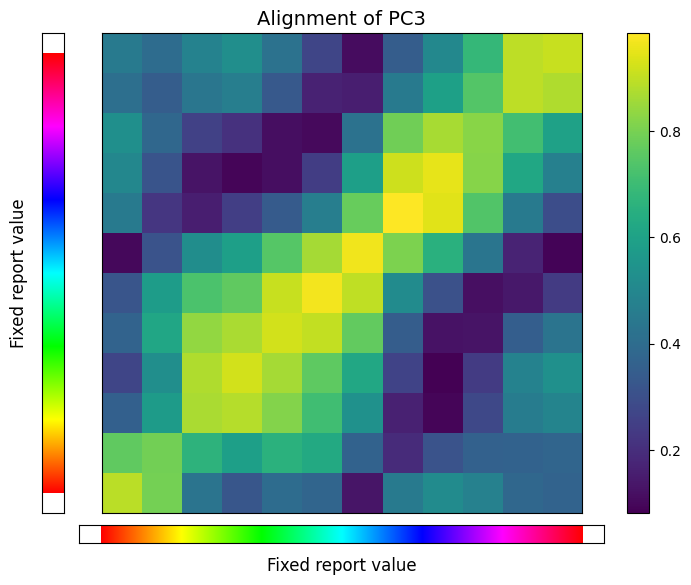

In [223]:
all_cross_post_comps_cosines = np.zeros([len(across_fixed_report_all_post_comps), len(across_fixed_report_all_post_comps)])

for i1, all_post_comps1 in enumerate(across_fixed_report_all_post_comps):
    for i2, all_post_comps2 in enumerate(across_fixed_report_all_post_comps):
        
        all_post_comps1_stacked = torch.tensor(np.stack(all_post_comps1, 1))  # [3D, difference probe combinations, N = 16]
        all_post_comps2_stacked = torch.tensor(np.stack(all_post_comps2, 1))  # [3D, difference probe combinations, N = 16]

        triu_indices = torch.triu_indices(len(all_post_comps1), len(all_post_comps1), 1)
        cross_post_comps_cosines = torch.mm(all_post_comps1_stacked[2], all_post_comps2_stacked[2].T).abs()[*triu_indices]

        all_cross_post_comps_cosines[i1, i2] = cross_post_comps_cosines.mean()


# fig, ax = create_imshow_with_rgb_axis_gradients(all_cross_post_comps_cosines, cmap=make_pastel_cmap('viridis', 0.2))
fig, main_ax, [x_gradient_ax, y_gradient_ax] = create_perfect_rgb_gradients(
        all_cross_post_comps_cosines, 
        cmap='viridis',
        figsize=(7.5, 6.0),
        title="Alignment of PC3",
        x_label="Fixed report value",
        y_label="Fixed report value"
    )

x_gradient_ax.set_xticks([])
y_gradient_ax.set_yticks([])
main_ax.set_yticks([])
main_ax.set_xticks([])

main_ax.set_xlim(-0.5, 11.5)
main_ax.set_ylim(-0.5, 11.5)

fig.savefig('neurips_figures/misprojection/PC3_alignment.svg', transparent = True)

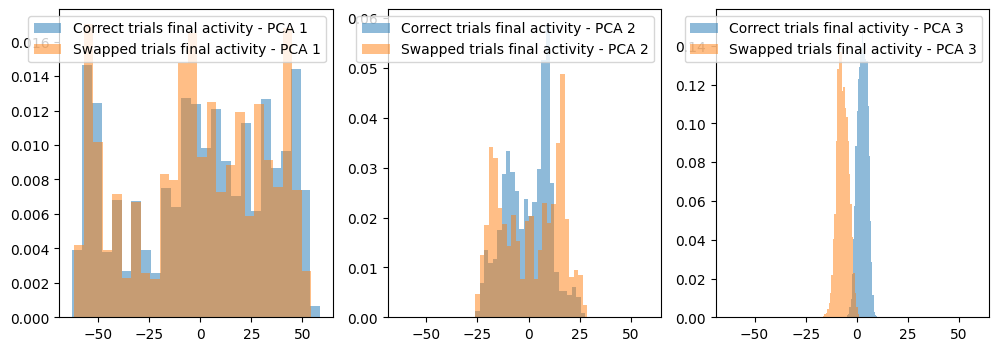

In [108]:
all_projection_pcaed = across_fixed_report_all_projection_pcaed[0]
all_many_trials_swapped_trials = across_fixed_report_all_many_trials_swapped_trials[0]

all_swaped_pcas = np.concatenate([pca4[pcast] for pca4, pcast in zip(all_projection_pcaed, all_many_trials_swapped_trials)], 0)
all_nonswaped_pcas = np.concatenate([pca4[~pcast] for pca4, pcast in zip(all_projection_pcaed, all_many_trials_swapped_trials)], 0)

fig, axes = plt.subplots(1, 3, figsize = (12, 4), sharex = True)
for i, (sp, nsp) in enumerate(zip(all_swaped_pcas, all_nonswaped_pcas[:3])):
    axes[i].hist(all_nonswaped_pcas[:,i], 25, alpha = 0.5, label = f'Correct trials final activity - PCA {i+1}', density = True)
    axes[i].hist(all_swaped_pcas[:,i], 25, alpha = 0.5, label = f'Swapped trials final activity - PCA {i+1}', density = True)
    axes[i].legend()

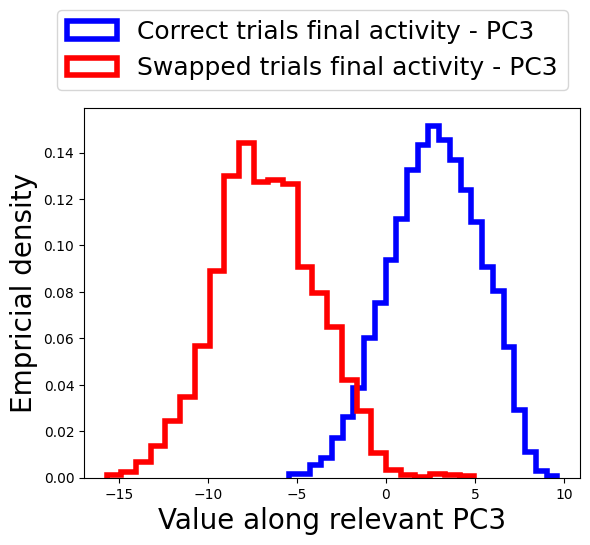

In [222]:
all_projection_pcaed = across_fixed_report_all_projection_pcaed[0]
all_many_trials_swapped_trials = across_fixed_report_all_many_trials_swapped_trials[0]

all_swaped_pcas = np.concatenate([pca4[pcast] for pca4, pcast in zip(all_projection_pcaed, all_many_trials_swapped_trials)], 0)
all_nonswaped_pcas = np.concatenate([pca4[~pcast] for pca4, pcast in zip(all_projection_pcaed, all_many_trials_swapped_trials)], 0)

fig, axes = plt.subplots(1)

axes.hist(all_nonswaped_pcas[:,2], 25, histtype=u'step', linewidth = 4, color = 'blue', density = True, label = 'Correct trials final activity - PC3')
axes.hist(all_swaped_pcas[:,2], 25, histtype=u'step', linewidth = 4, color = 'red', density = True, label = 'Swapped trials final activity - PC3')

axes.set_xlabel('Value along relevant PC3', fontsize = 20)
axes.set_ylabel('Empricial density', fontsize = 20)

axes.legend(fontsize = 18, bbox_to_anchor=(1.0, 1.3))

In [ ]:
ddpm_model.